<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Fresnel-based DOE Stokes 0 level influence</font>
</div>

- **Fecha**: 2022/04/26
        
- **Autores**: 
    - Jesús del hoyo
    - Javier Alda
    - Luis Miguel Sánchez Brea

   
- **Estado**:  Funciona, se valida la prueba de concepto (**guardar**). 

- **Objetivos**: 
    - Estudio del efecto de la transparencia del nivel de 0 en los errores.
    - Corrección del error provocado por tener un nivel de 0 elevado.
   

- **Descripción** 

- **Referencias**: Based on diffractio py module

- **Conclusiones**: 


# Importaciones

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import diffractio
import matplotlib as mpl

from diffractio import degrees, mm, plt, sp, um, np, nm

In [3]:
from py_pol.jones_matrix import Jones_matrix, Jones_vector

d:\codigo\py_pol\py_pol\jones_matrix.py:293: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other.type is 'Jones_vector':
d:\codigo\py_pol\py_pol\jones_matrix.py:981: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if global_phase is not 0:
d:\codigo\py_pol\py_pol\jones_matrix.py:1174: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if global_phase is not 0:
d:\codigo\py_pol\py_pol\jones_matrix.py:1310: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if global_phase is not 0:
d:\codigo\py_pol\py_pol\jones_matrix.py:1712: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if global_phase is not 0:
d:\codigo\py_pol\py_pol\utils.py:175: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if new_obj._type is 'Jones_vector':
d:\codigo\py_pol\py_pol\utils.py:181: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif new_obj._type is 'Jones_matrix':
d:\codigo\py_pol\py_pol\jones_vector.py:215: SyntaxWarning: "is" with 

In [4]:
from py_aocg.stokes_analyzer.stokes_analyzer_class import Stokes_analyzer, vectors_standard, jones_standard, Detector, diffraction_matrix_standard

In [5]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [6]:
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.pad_inches']=0.05
# mpl.rcParams['figure.subplot.hspace']=0
# mpl.rcParams['figure.subplot.wspace']=0
# mpl.rcParams['figure.subplot.left']=0.075

## Mascara multilentes con 6 niveles

In [21]:
num_sectors = 6
focal = 200 * mm
r_shift = 1.5*mm
detector_radius = 150*um
order=(1,2,3,4,5,6)

In [22]:
num_pixels = 512
length = 6*mm

x0 = np.linspace(-length / 2, length / 2, num_pixels)
y0 = np.linspace(-length / 2, length / 2, num_pixels)
wavelength = 0.6238 * um

(<diffractio.scalar_masks_XY.Scalar_mask_XY at 0x29dd5e41d90>,
 <diffractio.scalar_masks_XY.Scalar_mask_XY at 0x29dd5125250>)

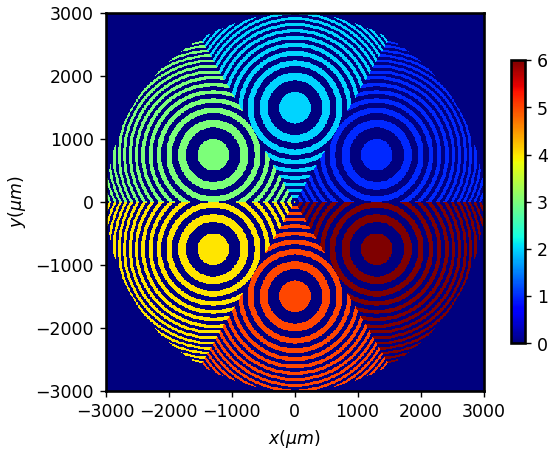

In [23]:
mpl.rcParams['figure.figsize']=(5,4)

stokes_analyzer = Stokes_analyzer(x0, y0, wavelength, num_sectors, focal, r_shift)
stokes_analyzer.order = order
stokes_analyzer.lens_indexes(order, has_draw=True)


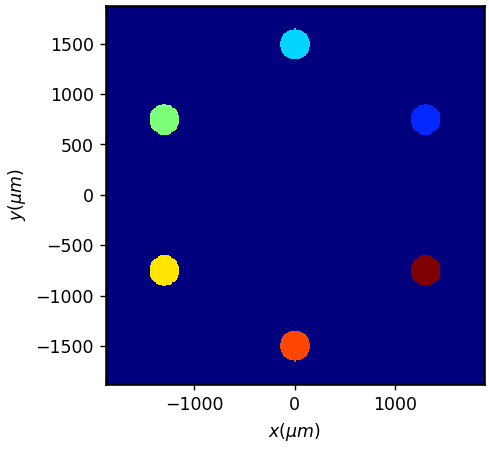

In [24]:
# Detector
detector_1 = Detector(x0, y0, wavelength,num_sectors, r_shift, order)
detector_1.circular(detector_radius)
stokes_analyzer.set_detector(detector_1, True)

## Bucle con transmision del nivel de 0 creciente

Voy a hacer un bucle con una transmision desde 0 hasta 1 y voy a medir los errores. 

### Sin corrección de errores

In [55]:
# Parametros del bucle
N = 11
Errores = np.zeros((N, 6))
trans = np.linspace(0, 1, N)

# Bucle en transmision
for ind, t in enumerate(trans):
    # Mascara vectorial
    stokes_analyzer.lens_vector(jones_matrices=jones_standard, has_draw=False, trans=t)
    # Calculo error
    _, _, Errores[ind, :] = stokes_analyzer.compute_stokes_several(vectors_standard,
                               z_obs=focal,
                               u=1,
                               diffraction_matrix=np.eye(6),
                               filter=False,
                               has_draw=False)    

In [57]:
# Plot errores
plt.figure()
plt.plot(trans**2, Errores*100)
plt.xlabel("Intensity trans.")
plt.ylabel("Error (%)")
plt.legend(("0", "45", "90", "135", "R", "L"))

Errores que crecen mucho segun la transmitividad del nivel de 0 crece y las lentes pierden poder difractivo, mandando más y más luz al fondo. Lo esperado.

### Con corrección de errores

Voy a probar si la corrección de errores facil implementadapor Luismi vale. Yo diría que funcionará bien para transmitancias bajas pero no para altas.

In [58]:
%%time
# Parametros del bucle
N = 11
Errores = np.zeros((N, 6))
trans = np.linspace(0, 1, N)

# Bucle en transmision
for ind, t in enumerate(trans):
    # Mascara vectorial
    stokes_analyzer.lens_vector(jones_matrices=jones_standard, has_draw=False, trans=t)
    # Correction matrix
    diffraction_matrix = stokes_analyzer.get_diffraction_matrix(vectors_standard, has_draw=False, verbose=False)
    # Calculo error
    _, _, Errores[ind, :] = stokes_analyzer.compute_stokes_several(vectors_standard,
                               z_obs=focal,
                               u=1,
                               diffraction_matrix=diffraction_matrix,
                               filter=False,
                               has_draw=False)    

CPU times: total: 2min 3s
Wall time: 2min 3s


In [59]:
# Plot errores
plt.figure()
plt.plot(trans**2, Errores*100)
plt.xlabel("Intensity trans.")
plt.ylabel("Error (%)")
plt.legend(("0", "45", "90", "135", "R", "L"))

Efectivamente, esa corrección no sirve. Tengo que implementar la mia. 

## Investigación sobre el problema

El primer paso es descubrir por qué falla el cálculo y la corrección de Luismi. Para eso voy a hacer dos ejemplor, con t = 0 y t = 0.8, en los extremos.

[1.     0.0023 0.0017 0.0006 0.0009 0.0021]
[0.0023 1.     0.0023 0.0009 0.0012 0.0009]
[0.0017 0.0023 1.     0.0021 0.0009 0.0006]
[0.0006 0.0009 0.0021 1.     0.0023 0.0017]
[0.0009 0.0012 0.0009 0.0023 1.     0.0023]
[0.0021 0.0009 0.0006 0.0017 0.0023 1.    ]


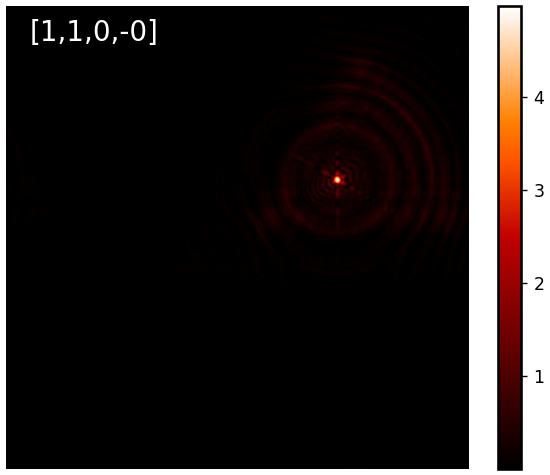

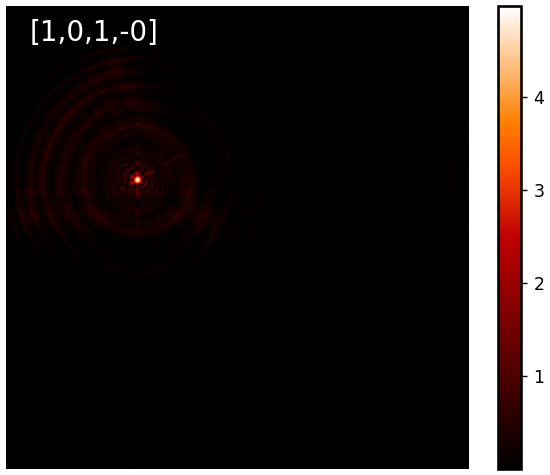

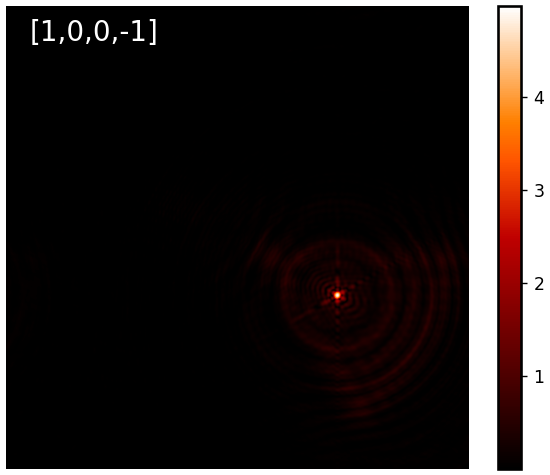

In [60]:
stokes_analyzer.lens_vector(jones_matrices=jones_standard, has_draw=False, trans=0)
diffraction_matrix= stokes_analyzer.get_diffraction_matrix(vectors_standard, has_draw=True)

[1.     0.006  0.001  0.0003 0.0006 0.0061]
[0.0062 1.     0.0062 0.0006 0.0013 0.0006]
[0.001  0.006  1.     0.0061 0.0006 0.0003]
[0.0003 0.0006 0.0061 1.     0.006  0.001 ]
[0.0006 0.0013 0.0006 0.0062 1.     0.0062]
[0.0061 0.0006 0.0003 0.001  0.006  1.    ]


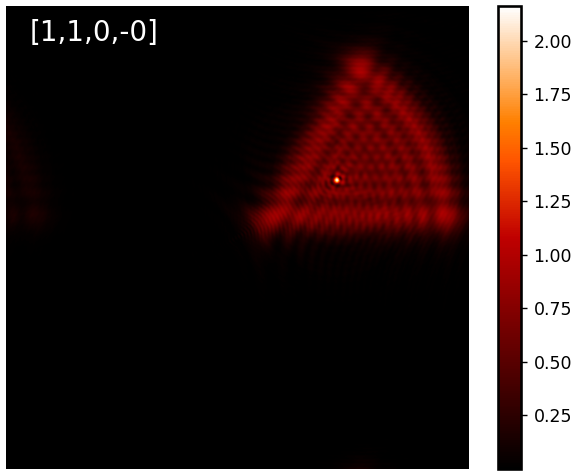

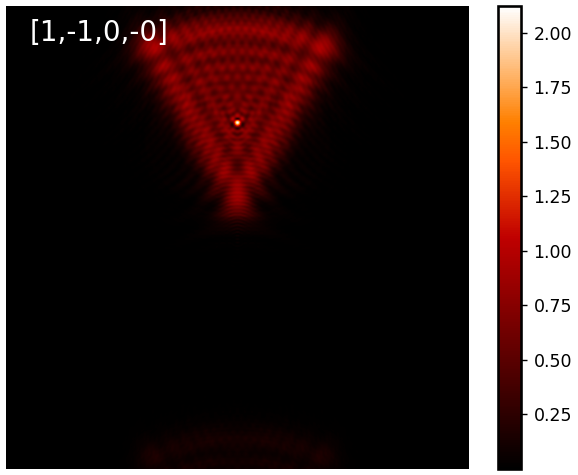

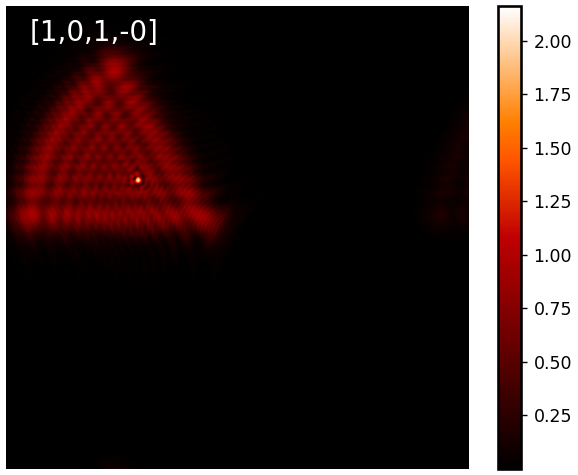

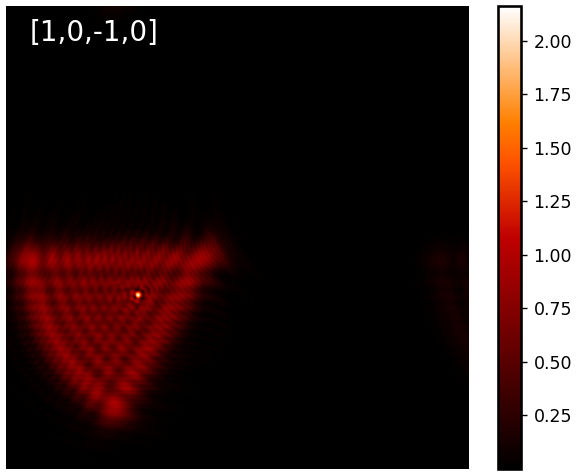

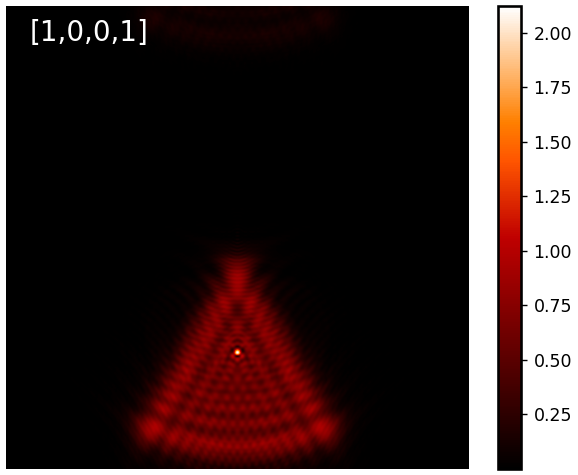

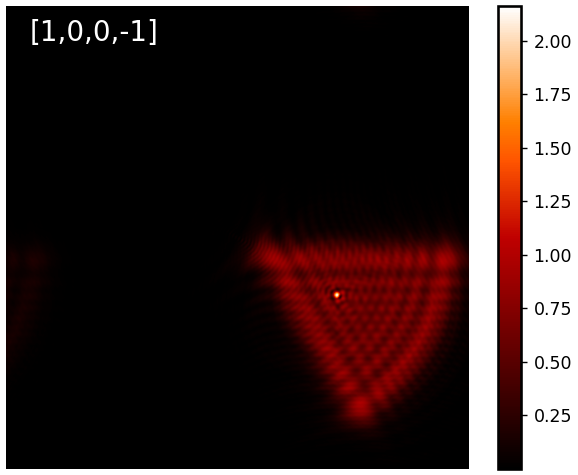

In [61]:
stokes_analyzer.lens_vector(jones_matrices=jones_standard, has_draw=False, trans=0.8)
diffraction_matrix= stokes_analyzer.get_diffraction_matrix(vectors_standard, has_draw=True)

Las matrices de corrección (que miran la cantidad de luz introducida por un sextante en otro) apenas varía. El principal efecto del cambio de transparencia es la reducción en la eficiencia de difracción. Eso supone que el pico es mucho menos intenso respecto al fondo que le rodea. 

Voy a calcular cómo afecta la transparencia a la medida, a ver si puedo encontrar una manera de corregir el problema.

In [63]:
%%time
# Parametros del bucle
N = 11
Signals = np.zeros((N, 6))
Signals_mean = np.zeros((N, 6))
trans = np.linspace(0, 1, N)

# Bucle en transmision
for ind, t in enumerate(trans):
    # Mascara vectorial
    stokes_analyzer.lens_vector(jones_matrices=jones_standard, has_draw=False, trans=t)
    # Correction matrix
    _, Signals[ind, :], Signals_mean[ind, :] = stokes_analyzer.get_diffraction_matrix(vectors_standard, has_draw=False, verbose=False, return_signals=True)

CPU times: total: 1min 2s
Wall time: 1min 2s


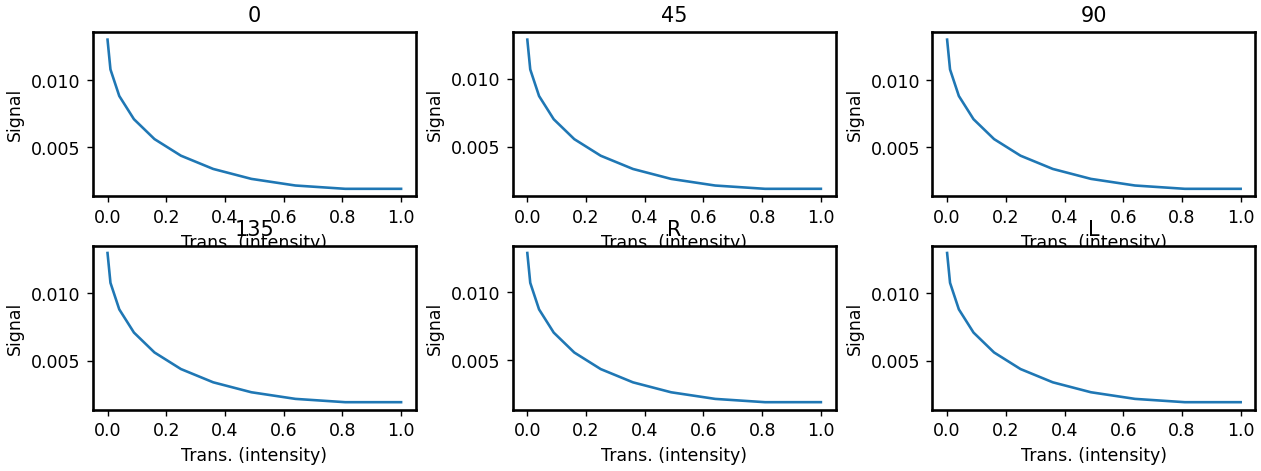

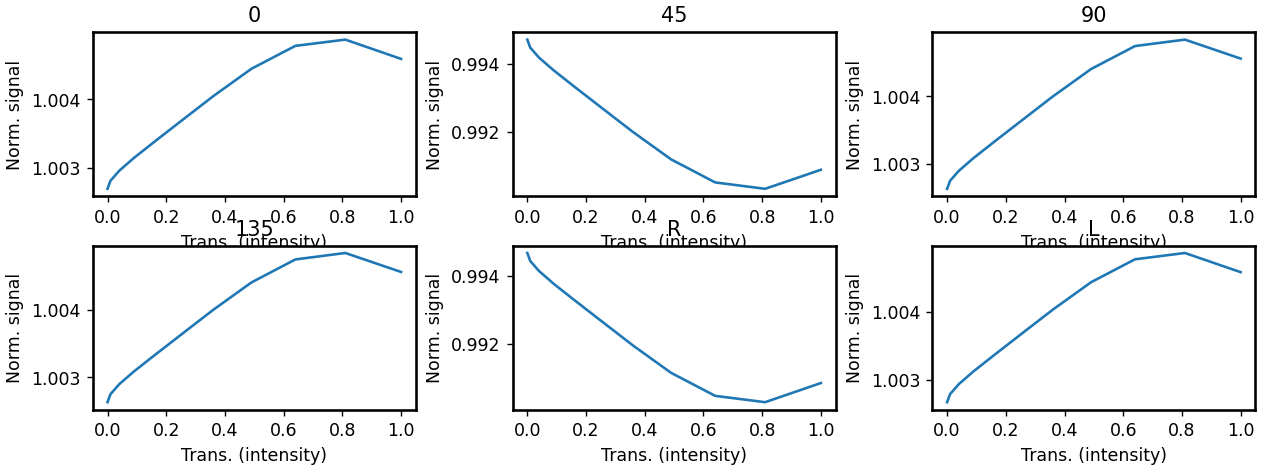

In [65]:
# Plot errores
titles = ("0", "45", "90", "135", "R", "L")
mpl.rcParams['figure.subplot.hspace']=0.3
mpl.rcParams['figure.subplot.wspace']=0.3
mpl.rcParams['savefig.pad_inches']=0.05

plt.figure(figsize=(12,4))
for ind in range(6):
    plt.subplot(2,3,ind+1)
    plt.plot(trans**2, Signals[:,ind])
    plt.xlabel("Trans. (intensity)")
    plt.ylabel("Signal")
    plt.title(titles[ind])
    
plt.figure(figsize=(12,4))
for ind in range(6):
    plt.subplot(2,3,ind+1)
    plt.plot(trans**2, Signals_mean[:,ind])
    plt.xlabel("Trans. (intensity)")
    plt.ylabel("Norm. signal")
    plt.title(titles[ind])

Puesto que la intensidad en todos los sectores cae de la misma amnera (la normalizacion es al promedio de las 6), no entiendo por qué aparecen los errores.

**NOTA:** Gracias a esto se han corregido unos cuantos bugs de diffractio y py_aocg puesto que las curvas salían de diferentes niveles promedio.

**NOTA 2:** Incluso con t=0, los promedios no salen iguales. Yo creo que esto es debido a la pixelixación, y aque en los sectores verticales sale una media un poquito menor y en el resto un poquito mayor. Seguramente con más píxeles esta diferencia bajaría.

Ahora voy a comprobar que ocurre en cada caso con todas las intensidades, no solo la propia. La teoría dice que la ortogonal debería dar 0, y que las demás deberían dar la mitad. A ver si es verdad.

In [25]:
%%time
# Parametros del bucle
N = 11
Signals = np.zeros((N, 6, 6))
Signals_mean = np.zeros((N, 6, 6))
trans = np.linspace(0, 1, N)

# Bucle en transmision
for ind, t in enumerate(trans):
    # Mascara vectorial
    stokes_analyzer.lens_vector(jones_matrices=jones_standard, has_draw=False, trans=t)
    # Calculo señales
    Signals[ind, :, :], _, _, Signals_mean[ind, :, :] = stokes_analyzer.compute_stokes_several(vectors_standard,
                               z_obs=focal,
                               u=1,
                               diffraction_matrix=np.eye(6),
                               filter=False,
                               has_draw=False,
                               return_mean=True)  

CPU times: total: 1min
Wall time: 1min


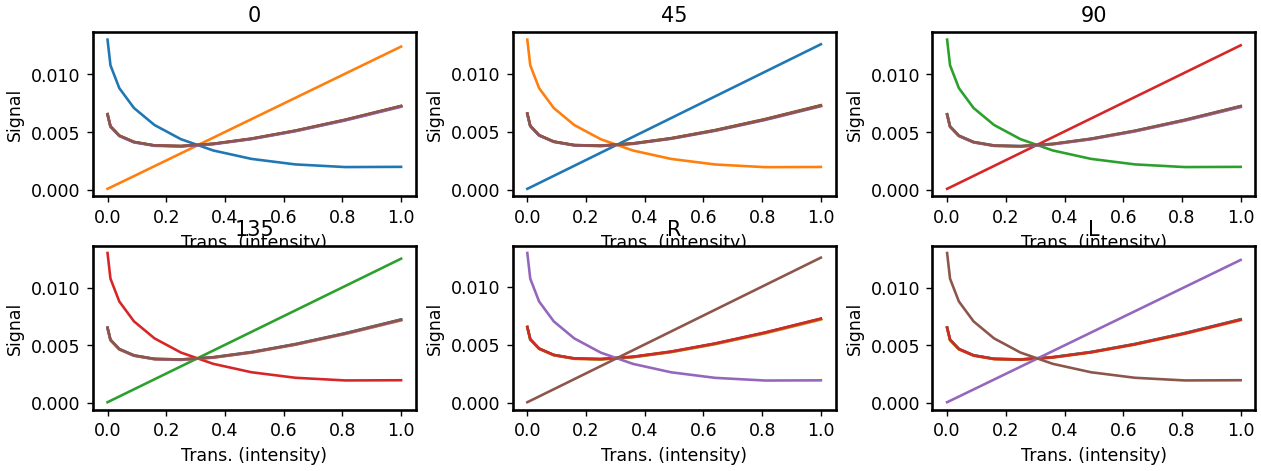

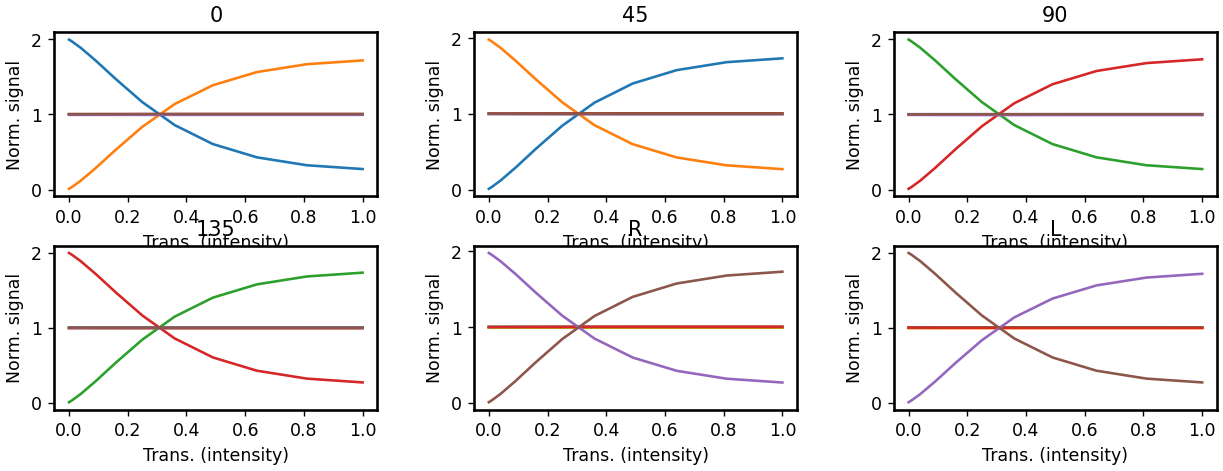

In [26]:
# Plot errores
titles = ("0", "45", "90", "135", "R", "L")
mpl.rcParams['figure.subplot.hspace']=0.3
mpl.rcParams['figure.subplot.wspace']=0.3
mpl.rcParams['savefig.pad_inches']=0.05

plt.figure(figsize=(12,4))
for ind in range(6):
    plt.subplot(2,3,ind+1)
    plt.plot(trans**2, Signals[:,ind, :])
    plt.xlabel("Trans. (intensity)")
    plt.ylabel("Signal")
    plt.title(titles[ind])
    
plt.figure(figsize=(12,4))
for ind in range(6):
    plt.subplot(2,3,ind+1)
    plt.plot(trans**2, Signals_mean[:,ind, :])
    plt.xlabel("Trans. (intensity)")
    plt.ylabel("Norm. signal")
    plt.title(titles[ind])

Esto es muy muy interesante. Yo he implementado la transparencia de nivel como un filtro neutro pero sin aplicarle el polarizador que toca a cada cuadrante. Por eso, el sector que debe dar una intensidad medida de 0, cada vez da más intensidad hasta que rápidamente supera a la señal correcta. Esto quiere decir que podemos usar una máscara parcialmente transparente (como las impresas con nuestra impresora) siempre que todo el sextante tenga el estado correcto. Voy a comprobarlo para estar seguro.

## Máscara de transmisión difractiva + máscara de polarización

La idea es que, en este caso, tenemos por un lado una máscara difractiva de amplitud insensible a la polarización, y por otro una máscara de polarización en sectores no difractiva.

(<diffractio.scalar_masks_XY.Scalar_mask_XY at 0x29dd5e41850>,
 <diffractio.scalar_masks_XY.Scalar_mask_XY at 0x29dd631f880>)

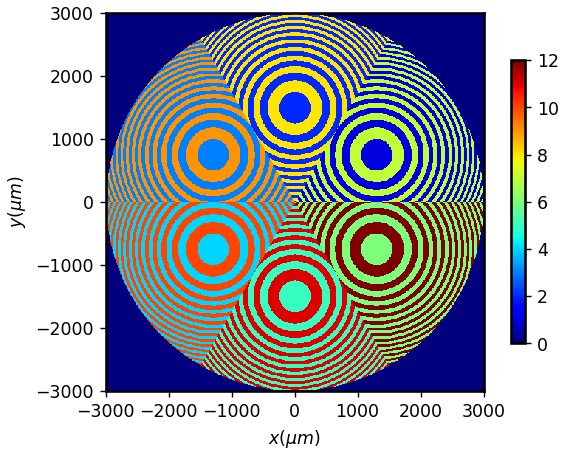

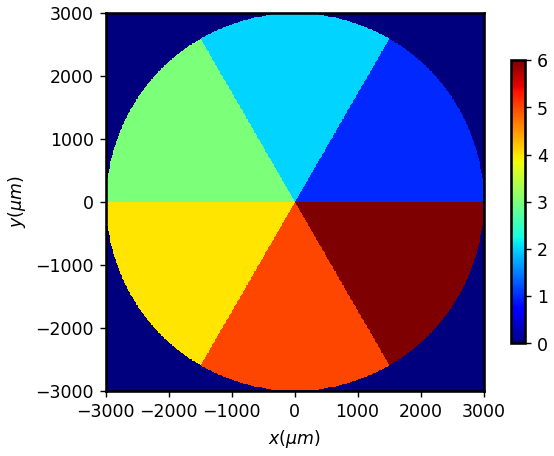

In [25]:
trans_0 = 0.5
stokes_analyzer = Stokes_analyzer(x0, y0, wavelength, num_sectors, focal, r_shift, trans_0=trans_0)
stokes_analyzer.order = order
stokes_analyzer.lens_indexes(order, has_draw=True, return_sectors=True)

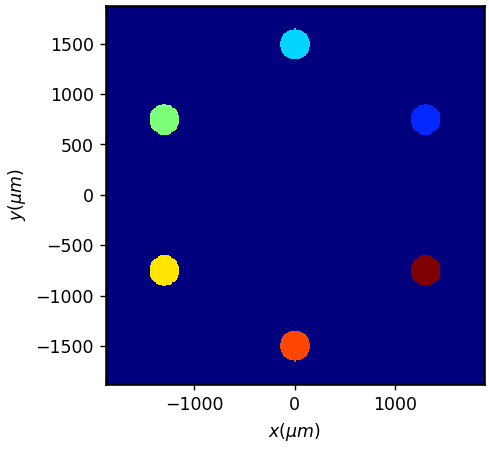

In [26]:
detector_1 = Detector(x0, y0, wavelength,num_sectors, r_shift, order)
detector_1.circular(detector_radius)
stokes_analyzer.set_detector(detector_1, True)

In [44]:
%%time
# Parametros del bucle
N = 51
Errores = np.zeros((N, 6))
Signals = np.zeros((N, 6, 6))
Signals_mean = np.zeros((N, 6, 6))
trans = np.linspace(0, 1, N)

# Bucle en transmision
for ind, t in enumerate(trans):
    # Mascara vectorial
    stokes_analyzer.lens_vector(jones_matrices=jones_standard, has_draw=False, trans=t)
    # Calculo señales
    Signals[ind, :, :], _, _, Signals_mean[ind, :, :] = stokes_analyzer.compute_stokes_several(vectors_standard,
                               z_obs=focal,
                               u=1,
                               diffraction_matrix=np.eye(6),
                               filter=False,
                               has_draw=False,
                               return_mean=True)  
    
    _, _, Errores[ind, :] = stokes_analyzer.compute_stokes_several(vectors_standard,
                               z_obs=focal,
                               u=1,
                               diffraction_matrix=np.eye(6),
                               filter=False,
                               has_draw=False)    

CPU times: total: 9min 2s
Wall time: 9min 4s


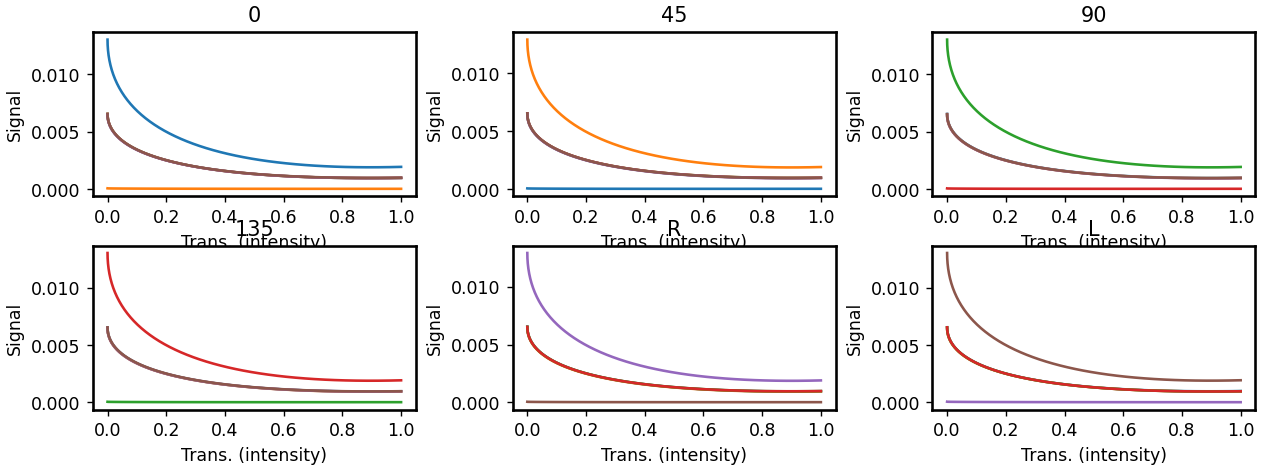

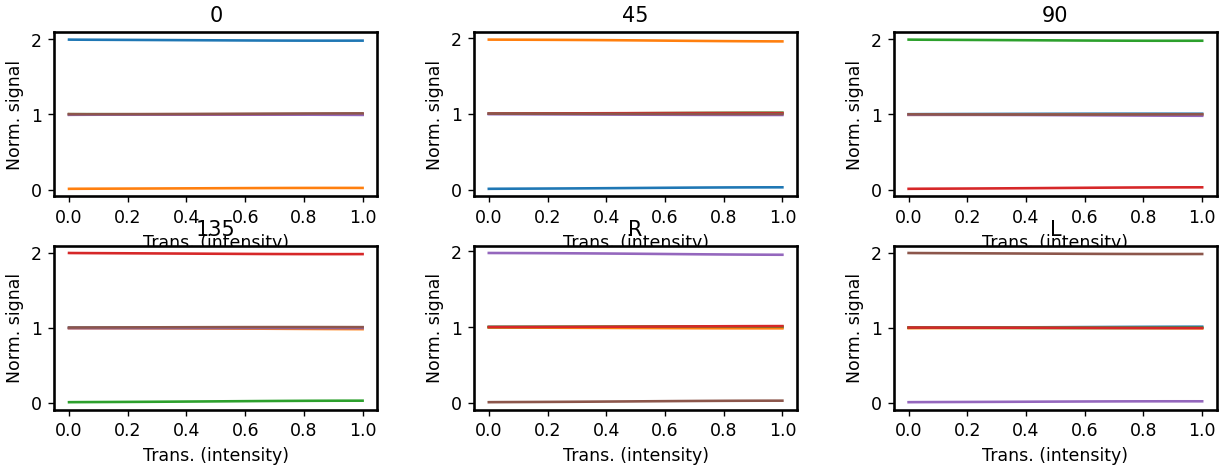

In [45]:
# Plot errores
titles = ("0", "45", "90", "135", "R", "L")
mpl.rcParams['figure.subplot.hspace']=0.3
mpl.rcParams['figure.subplot.wspace']=0.3
mpl.rcParams['savefig.pad_inches']=0.05

plt.figure(figsize=(12,4))
for ind in range(6):
    plt.subplot(2,3,ind+1)
    plt.plot(trans**2, Signals[:,ind, :])
    plt.xlabel("Trans. (intensity)")
    plt.ylabel("Signal")
    plt.title(titles[ind])
    
plt.figure(figsize=(12,4))
for ind in range(6):
    plt.subplot(2,3,ind+1)
    plt.plot(trans**2, Signals_mean[:,ind, :])
    plt.xlabel("Trans. (intensity)")
    plt.ylabel("Norm. signal")
    plt.title(titles[ind])

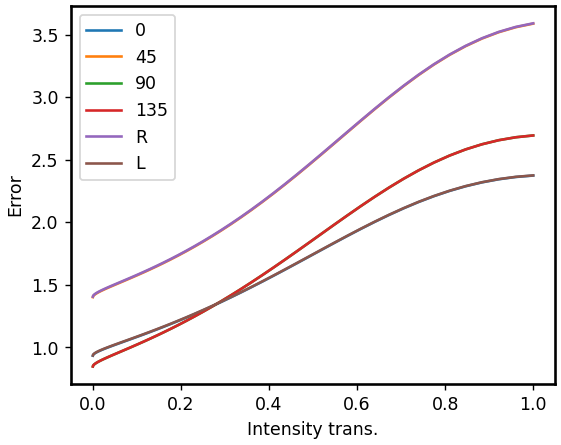

In [46]:
# Plot errores
plt.figure()
plt.plot(trans**2, Errores*100)
plt.xlabel("Intensity trans.")
plt.ylabel("Error (%)")
plt.legend(("0", "45", "90", "135", "R", "L"))

Un resultado genial. Ahora con la corrección.

### Errores con corrección

In [47]:
%%time
# Parametros del bucle
N = 21
Errores = np.zeros((N, 6))
trans = np.linspace(0, 1, N)

# Bucle en transmision
for ind, t in enumerate(trans):
    # Mascara vectorial
    stokes_analyzer.lens_vector(jones_matrices=jones_standard, has_draw=False, trans=t)
    # Correction matrix
    diffraction_matrix = stokes_analyzer.get_diffraction_matrix(vectors_standard, has_draw=False, verbose=False)
    # Calculo error
    _, _, Errores[ind, :] = stokes_analyzer.compute_stokes_several(vectors_standard,
                               z_obs=focal,
                               u=1,
                               diffraction_matrix=diffraction_matrix,
                               filter=False,
                               has_draw=False)    

CPU times: total: 4min 4s
Wall time: 4min 6s


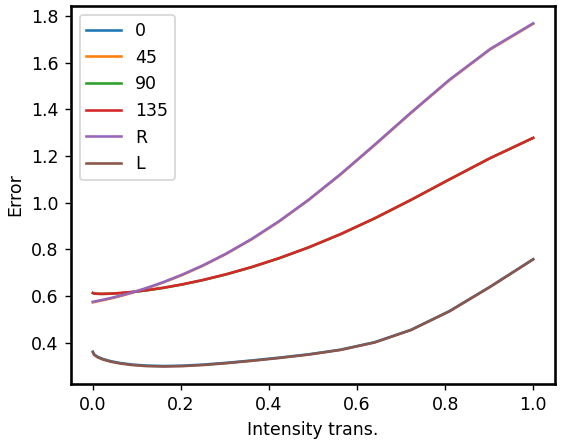

In [48]:
# Plot errores
plt.figure()
plt.plot(trans**2, Errores*100)
plt.xlabel("Intensity trans.")
plt.ylabel("Error (%)")
plt.legend(("0", "45", "90", "135", "R", "L"))

Están muy bien, la mitad.

## SLM

Ahora voy a usar el SLM en lugar de los polarizadores ideales, a ver qué ocurre.

In [27]:
# Cargar datos del SLM
data = np.load("SLM_Jones_components.npz")
J0 = data["J0"] * np.exp(1j * data["d0"])
J1 = data["J1"] * np.exp(1j * data["d1"])
J2 = data["J2"] * np.exp(1j * data["d2"])
J3 = data["J3"] * np.exp(1j * data["d3"])
Jslm = Jones_matrix("SLM").from_components([J0, J1, J2, J3])

In [28]:
# Cargar datos de la optimizacion de parámetros experimentales
data = np.load("Optimizacion_SLM+PSA_polarimetria.npz")
Wi = data["Wi"]
indices = data["indices"]
angles = data["angles"]

In [29]:
# Crear lista de estados
Jr = Jones_matrix("R").quarter_waveplate(azimuth=angles[0]*degrees)
Jd = Jones_matrix("P").diattenuator_perfect(azimuth=angles[1]*degrees)
PSA = Jd * Jr
jones_slm = []
for ind in indices:
    jones_slm.append(PSA * Jslm[ind])
jones0 = Jslm[0]

In [30]:
%%time
# Parametros del bucle
N = 21
Errores = np.zeros((N, 6))
trans = np.linspace(0, 1, N)

# Bucle en transmision
for ind, t in enumerate(trans):
    # Mascara vectorial
    stokes_analyzer.lens_vector(jones_matrices=jones_slm, has_draw=False, trans=t)
    # Calculo error
    _, _, Errores[ind, :] = stokes_analyzer.compute_stokes_several(vectors_standard,
                               z_obs=focal,
                               u=1,
                               diffraction_matrix=np.eye(6),
                               filter=False,
                               has_draw=False,
                                Wi=Wi)    

CPU times: total: 1min 59s
Wall time: 2min


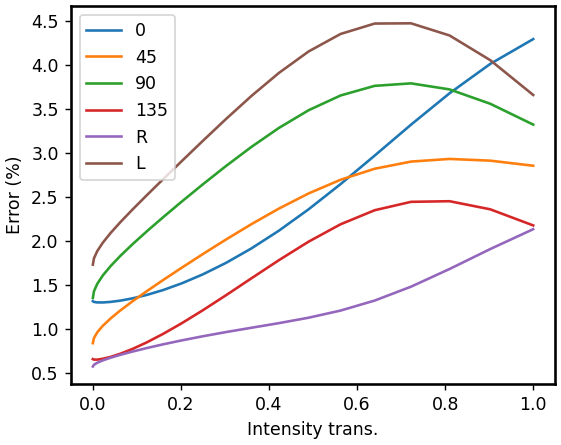

In [32]:
# Plot errores
plt.figure()
plt.plot(trans**2, Errores*100)
plt.xlabel("Intensity trans.")
plt.ylabel("Error (%)")
plt.legend(("0", "45", "90", "135", "R", "L"))

# Conclusiones

1. Utilizar una máscara "barata" de plástico con polarizadores ideales funciona perfectamente, el error es un porcentaje bajo.
1. Con el SLM ocurre lo mismo, se puede utilizar la máscara de plástico barata para el experimento.
1. El resultado nos dice que, en el límite de no tener máscara difractiva (t = 1), la medida sigue siendo muy buena. Es decir, si podemos garantizar que todos los detectores tienen la misma área, la medida es buena. Eso complica el vender la idea, pero es algo que no tenemos por qué contar al principio.

Yo creo que, a la vista de esto, merece la pena hacer el experimento con la máscara de plástico.